In [3]:
import torch
import sys
import os
sys.path.append('..')

from src.models.lstm import LSTMSentiment
from src.data.dataset import get_data_loaders
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline
sns.set_style('whitegrid')

In [4]:
# Configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Load data to get vocabulary
print("\nLoading vocabulary...")
_, test_loader, vocab = get_data_loaders(batch_size=32)

# Create model
print("Creating model...")
model = LSTMSentiment(
    vocab_size=len(vocab),
    embedding_dim=300,
    hidden_dim=256,
    n_layers=2,
    bidirectional=True
).to(device)

# Load checkpoint
checkpoint_path = '../checkpoints/best_model.pth'

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    print(f"✓ Model loaded from {checkpoint_path}")
    print(f"  Best accuracy: {checkpoint['best_accuracy']*100:.2f}%")
else:
    print("⚠ No checkpoint found. Please train the model first:")
    print("  python experiments/train.py")

Using device: cpu

Loading vocabulary...
Loading IMDB dataset...
Creating synthetic dataset for demonstration...
To use real IMDB data, download from: http://ai.stanford.edu/~amaas/data/sentiment/
Building vocabulary...


100%|██████████| 1000/1000 [00:00<00:00, 81586.96it/s]

Vocabulary size: 32

Dataset Statistics:
  Training samples: 1000
  Test samples: 200
  Vocabulary size: 32
  Max sequence length: 256
Creating model...
✓ Model loaded from ../checkpoints/best_model.pth
  Best accuracy: 100.00%


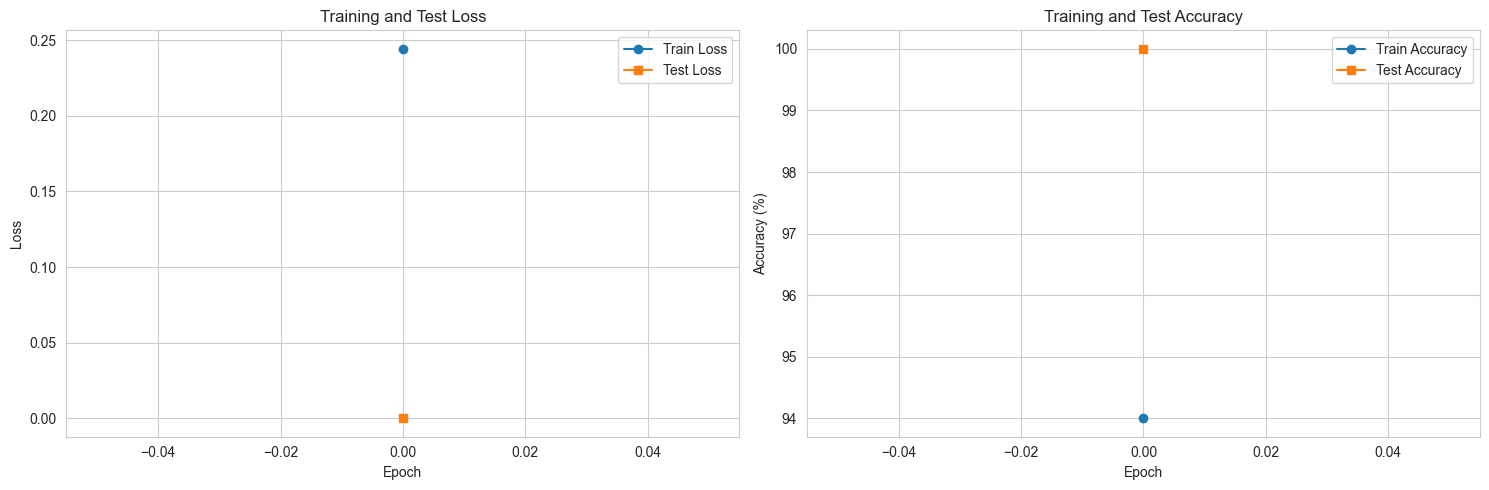

In [5]:
# Plot training history
train_losses = checkpoint['train_losses']
test_losses = checkpoint['test_losses']
train_accs = checkpoint['train_accuracies']
test_accs = checkpoint['test_accuracies']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(train_losses, label='Train Loss', marker='o')
ax1.plot(test_losses, label='Test Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Test Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot([x*100 for x in train_accs], label='Train Accuracy', marker='o')
ax2.plot([x*100 for x in test_accs], label='Test Accuracy', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Test Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
# Make some predictions
test_reviews = [
    "This movie was absolutely amazing! Best film I've seen all year.",
    "Terrible waste of time. Boring and predictable plot.",
    "Not bad, but could have been better. Average at best.",
]

def predict_sentiment(text):
    # Simple preprocessing
    tokens = text.lower().split()
    sequence = [vocab.get(t, vocab['<UNK>']) for t in tokens]
    
    # Pad
    max_len = 256
    length = min(len(sequence), max_len)
    if len(sequence) < max_len:
        sequence = sequence + [vocab['<PAD>']] * (max_len - len(sequence))
    else:
        sequence = sequence[:max_len]
    
    # Predict
    text_tensor = torch.tensor([sequence]).to(device)
    length_tensor = torch.tensor([length])
    
    with torch.no_grad():
        output = model(text_tensor, length_tensor)
        probs = torch.softmax(output, dim=1)
        pred = output.argmax(dim=1).item()
    
    sentiment = "Positive 😊" if pred == 1 else "Negative 😞"
    confidence = probs[0][pred].item() * 100
    
    return sentiment, confidence

print("Sample Predictions:\n")
for review in test_reviews:
    sentiment, conf = predict_sentiment(review)
    print(f"Review: {review[:50]}...")
    print(f"Sentiment: {sentiment} (Confidence: {conf:.1f}%)\n")

Sample Predictions:

Review: This movie was absolutely amazing! Best film I've ...
Sentiment: Positive 😊 (Confidence: 100.0%)

Review: Terrible waste of time. Boring and predictable plo...
Sentiment: Positive 😊 (Confidence: 100.0%)

Review: Not bad, but could have been better. Average at be...
Sentiment: Positive 😊 (Confidence: 100.0%)

